Chicago Traffic Data Visualization

In [1]:
# import essential libs
import google.datalab.bigquery as bq
import matplotlib.pyplot as plot
import numpy as np

Number of Segments

In [2]:
%%bq query
select count(distinct segmentid) from `project-slave-200906.chicago.traffic`;

f0_
1257


Number of Streets

In [3]:
%%bq query
select count(distinct street) from `project-slave-200906.chicago.traffic`;

f0_
71


Trips by Year (Raw Data)

In [4]:
%%bq query --name trips_by_year
select SAFE.SUBSTR(_last_updt,6,2) as month, count(*) as monthly_trip
  from `project-slave-200906.chicago.traffic`
  group by month
  order by month

In [5]:
results = trips_by_year.execute().result()

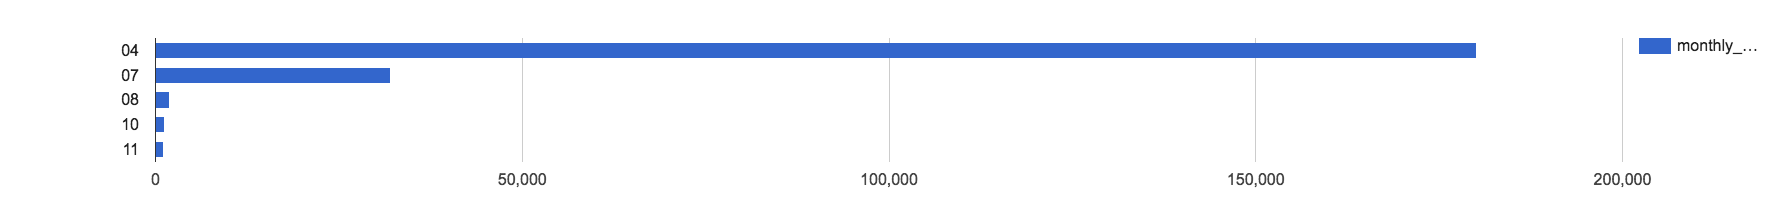

In [6]:
%%chart bars --data results

Daily Trips (using Transformed Data as Output from DataPrep)

In [7]:
%%bq query --name trips_by_day
select 
  FORMAT_DATE('%A', extract(DATE from last_updt)) AS dow,
  count(*) as daily_trip_count
  from `project-slave-200906.chicago.dataprep_a`
  group by dow
  order by
       CASE
          WHEN dow = 'Sunday' THEN 1
          WHEN dow = 'Monday' THEN 2
          WHEN dow = 'Tuesday' THEN 3
          WHEN dow = 'Wednesday' THEN 4
          WHEN dow = 'Thursday' THEN 5
          WHEN dow = 'Friday' THEN 6
          WHEN dow = 'Saturday' THEN 7
       END ASC

In [8]:
results_day = trips_by_day.execute().result()

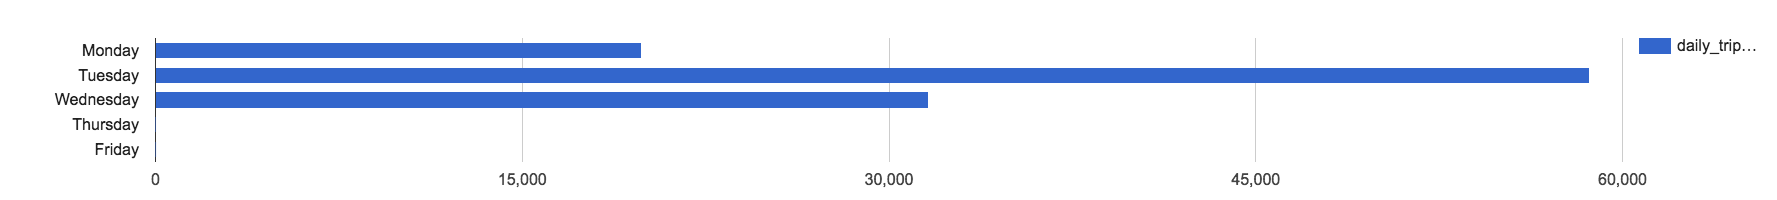

In [9]:
%%chart bars --data results_day

Max Speed on East Bound Traffic Flow

In [10]:
%%bq query --name street_trips_eb
select street as street, max(cast(_traffic as int64)) as max_traffic_speed_EB
  from `project-slave-200906.chicago.traffic`
  where cast(_traffic as int64) >= 0 and _direction = 'EB'
  group by street
  order by street

In [11]:
results = street_trips_eb.execute().result()

In [12]:
%%chart gauge --data results

Min Speed on East Bound Traffic Flow

In [13]:
%%bq query --name street_trips_eb
select street as street, min(cast(_traffic as int64)) as min_traffic_speed_EB
  from `project-slave-200906.chicago.traffic`
  where cast(_traffic as int64) >= 0 and _direction = 'EB'
  group by street
  order by street

In [14]:
results = street_trips_eb.execute().result()

In [15]:
%%chart gauge --data results

Time Series Build Up for From/To Street versus Speed.

In [16]:
%%bq query -n speed_logs
SELECT last_updt, traffic, street, fromst, tost
FROM `project-slave-200906.chicago.dataprep_a`
where cast(traffic as int64) >= 0 AND ( street = '55th' ) AND ( direction = 'EB' )
ORDER by last_updt

In [17]:
%%bq sample --query speed_logs --count 10

last_updt,traffic,street,fromst,tost
2018-04-16T16:30:55,18,55th,Central Park,Kedzie
2018-04-16T16:30:55,27,55th,California,Western
2018-04-16T16:30:55,21,55th,Pulaski,Central Park
2018-04-16T16:31:08,21,55th,Kostner,Pulaski
2018-04-16T16:31:15,12,55th,Narragansett,Austin
2018-04-16T16:31:15,20,55th,Cicero,Kostner
2018-04-16T16:31:15,36,55th,Laramie,Cicero
2018-04-16T17:01:12,18,55th,California,Western
2018-04-16T17:01:12,24,55th,Kedzie,California
2018-04-16T17:01:12,13,55th,Pulaski,Central Park


In [18]:
# Execute and convert the results to a Pandas dataframe
timeseries_df = speed_logs.execute(output_options=bq.QueryOutput.dataframe()).result()
timeseries_values = timeseries_df['traffic'].values
timeseries_len = len(timeseries_values)

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


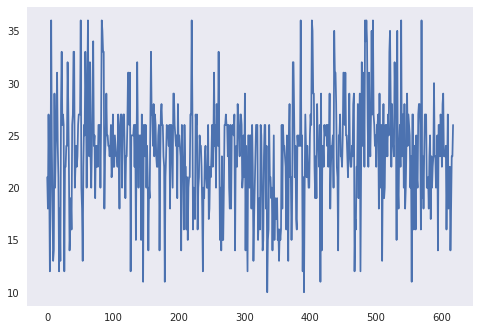

In [19]:
plot.plot(np.array(range(timeseries_len)), timeseries_values)
plot.grid()

Anomaly Detector

In [32]:
class AnomalyDetector(object):

  def __init__(self, window = 10):
    self._index = 0
    self._window = window
    self._values = np.zeros(window)
    self._valuesSq = np.zeros(window)
    self._mean = 0
    self._variance = 0
    self._count = 0

  def observation(self, value):
    anomaly = False
    if self._variance >= 0:
      threshold = 3/2 * np.sqrt(self._variance)
    else:
      threshold = 3/2 * np.sqrt(self._variance * -1)
    if self._count > self._window:
      if value > self._mean + threshold:
        value = self._mean + threshold
        anomaly = True
      elif value < self._mean - threshold:
        value = self._mean - threshold
        anomaly = True
    else:
      self._count += 1

    prev_value = self._values[self._index]
    self._values[self._index] = value
    self._valuesSq[self._index] = value ** 2
    self._index = (self._index + 1) % self._window

    self._mean = self._mean - prev_value / self._window + value / self._window
    self._variance = sum(self._valuesSq) / self._window - (self._mean ** 2)

    return anomaly, self._mean

In [33]:
anomalies = np.zeros(timeseries_len)
means = np.zeros(timeseries_len)
anomaly_detector = AnomalyDetector(36)
for i, value in enumerate(timeseries_values):
  anomaly, mean = anomaly_detector.observation(value)
  anomalies[i] = anomaly
  means[i] = mean

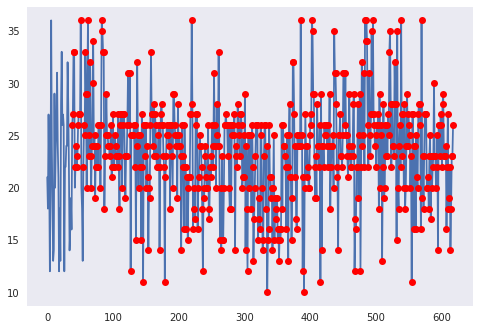

In [34]:
ticks = np.array(range(timeseries_len))
plot.plot(ticks, timeseries_values)
plot.plot(ticks[anomalies == 1], timeseries_values[anomalies == 1], 'ro')
plot.grid()